# <b>velocity embedding method using UMAP<b>

process :

- use UMAP parametrization to "learn" a function that go from 3D to 2D (on cells data)
- use this function to translate the velocity vector fied in 2D
- reverse the parametrisation in order to compare

test : 

- generate random cells in 3D and a random velocity vector field on it.
- go from 3D to 2D using the embedding method
- use the reverse function to go from 2D to 3D again
- compare reconstruction with original data 

# 0] <b>data and package<b>

In [77]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [78]:
import numpy as np #verify the version for tensorflow
np.__version__

'1.21.0'

In [79]:
import tensorflow as tf #for machine learning and parametric UMAP
import tensorflow_datasets as tfds
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.experimental.list_physical_devices('CPU')))

TensorFlow version: 2.8.0
Num GPUs Available:  1
Num CPUs Available:  1


In [80]:
from scipy.special import expit as activation_function #for custom machine learning method
from scipy.stats import truncnorm

In [81]:
import scvelo as scv #for velocity embedding 

In [82]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import umap
import random
%matplotlib inline
from umap.parametric_umap import ParametricUMAP

In [83]:
from math import acos
from math import sqrt
from math import pi
import matplotlib.cm as cm

In [84]:
from pca import pca

In [85]:
import pandas as pd

from sklearn import decomposition
from sklearn import datasets
from sklearn.preprocessing import scale

import anndata
from scipy import sparse

# 1] <b>implementation<b>

# Plot and processing

In [86]:
def Plot2D(C,save = '',title = '') :
    #plot
    plt.figure(figsize=(12, 12))
    
    if(title == '') :
        plt.title("UMAP simulation embedding")
    else :
        plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')

    plt.scatter(C[:, 0],
    C[:, 1])
    
    if(save != '') :
        plt.savefig(fname = 'graph/'+save+'.png')

    plt.show()

In [87]:
def plot3D(E,save = '',title = '') :
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(projection='3d')
    if(title == '') :
        ax.set_title('simulation of cells ')
    else :
        ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    #ax.set_xlim(-1,1)
    #ax.set_ylim(-1,1)
    #ax.set_zlim(-1,1)
    
    ax.scatter(E[:, 0],E[:, 1],E[:, 2])
    
    if(save != '') :
        plt.savefig(fname = 'graph/'+save+'.png')
        
    plt.show()

In [88]:
def plot_epoch(E,reconstruction,save = ''):
    
    plt.figure(figsize=(12, 12))
    plt.title("Minimisation of the cross entropy")
    if reconstruction :
        plt.plot(E._history['umap_loss'])
    else :
        plt.plot(E._history['loss'])
    plt.ylabel('Cross Entropy')
    plt.xlabel('Epoch')
    
    if(save != '') :
        plt.savefig(fname = 'graph/'+save+'.png')
        
    plt.show()

In [89]:
def Vector_plot(embedding,velocity,save = '',title = '',color = False) :
   
    if(velocity.shape[1] == 2) :
        norm = np.sqrt(velocity[:, 0]**2 + velocity[:, 1]**2) #normalisation
        velocity[:, 0] = velocity[:, 0]/norm 
        velocity[:, 1] = velocity[:, 1]/norm 
        if(color == True) :
            col = np.random.rand(velocity.shape[0])
            for i in range(velocity.shape[0]) :
                col[i] = angle_of_vector([1,0],velocity[i,:])
        
    #plot
    plt.figure(figsize=(12, 12))
    if(title == '') :
        plt.title("Velocity embedding")
    else :
        plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')
    
    plt.scatter(embedding[:, 0], embedding[:, 1])
    
    
    if(color == False) :
        plt.quiver(embedding[:, 0],embedding[:, 1],velocity[:, 0],velocity[:, 1], scale =50)
    else :
        plt.quiver(embedding[:, 0],embedding[:, 1],velocity[:, 0],velocity[:, 1], col, cmap = 'magma',scale =50)
        
    if(save != '') :
        plt.savefig(fname = 'graph/'+save+'.png')

    plt.show()

In [90]:
def Vector_plot3D(embedding,velocity, save = '', title = '') :
   
    if(velocity.shape[1] == 3) :
        norm = np.sqrt(velocity[:, 0]**2 + velocity[:, 1]**2 + velocity[:, 2]**2)*3#normalisation
        velocity[:, 0] = velocity[:, 0]/norm
        velocity[:, 1] = velocity[:, 1]/norm
        velocity[:, 2] = velocity[:, 2]/norm
        

        
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(projection='3d')

    ax.scatter(embedding[:, 0],embedding[:, 1],embedding[:, 2])
    ax.quiver(embedding[:, 0],embedding[:, 1],embedding[:, 2],velocity[:, 0],velocity[:, 1],velocity[:, 2])

    if(title == '') :
        ax.set_title('simulation of cells and velocities')
    else :
        ax.set_title(title)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    #ax.set_xlim(-1,1)
    #ax.set_ylim(-1,1)
    #ax.set_zlim(-1,1)
    
    if(save != '') :
        plt.savefig(fname = 'graph/'+save+'.png')

    plt.show()

In [91]:
def coloring(C,I,E,V = [], save = '', title = '') : #C original cells, I reconstructed data, E embedding
    dist = []
    for i in range(C.shape[0]) :
        dist.append(np.sqrt(np.sum(np.square(C[i]-I[i]))))
    
    #plot

    plt.figure(figsize=(12, 12))
    
    if(title == '') :
        plt.title("colored UMAP cells embedding")
    else :
        plt.title(title + " 2D")
    
    plt.xlabel('X')
    plt.ylabel('Y')

    plt.scatter(E[:, 0], E[:, 1],c = dist , cmap = "magma")
    
    if(V != []) :
        plt.quiver(E[:, 0],E[:, 1],V[:, 0],V[:, 1])

    
    if(save != '') :
        plt.savefig(fname = 'graph/'+save+'_2D.png')
        
    plt.show()
    
    #plot
    if(C.shape[1] == 3) :
        fig = plt.figure(figsize=(12, 12))
        ax = fig.add_subplot(projection='3d')

        ax.scatter(C[:, 0],C[:, 1],C[:, 2], c = dist , cmap = "magma")
        
        if(title == '') :
            ax.set_title('simulation of cells')
        else :
            ax.set_title(title + " 3D")
        
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        
        if(save != '') :
            plt.savefig(fname = 'graph/'+save+'_3D.png')
        
        plt.show()
    

In [92]:
def normalise(X) : 
    n = X.shape[1]
    M = 0.0
    for i in range(n) : 
        m = max(X[:,i])
        if m > M :
            M = m
    if M != 0.0 :
        X = X/M
    return X

In [93]:
def dist_point(C,I) :
    print("distance between cells")
    if(C.shape[0] != 0) :
        D = []
        for i in range(C.shape[0]) : 
            D.append(np.sqrt(np.sum(np.square(C[i]-I[i]))))
        print('mean : ', np.mean(D))
        print('max : ', np.max(D))
        print('min : ', np.min(D))
        return D
    else :
        print("error")
        return ()

In [156]:
def dist_vector(Vi,Vf) :
    print("distance between vector (in degree)")
    if(Vi.shape[0] != 0) :
        D = []
        for i in range(Vi.shape[0]) : 
            D.append(angle_of_vector(Vi[i],Vf[i]))
        print('mean : ', np.mean(D))
        print('median : ', np.median(D))
        print('max : ', np.max(D))
        print('min : ', np.min(D))
        return D
    else :
        print("error")
        return ()

In [149]:
def angle_of_vector_old(v1, v2):
    vector_prod = v1[0] * v2[0] + v1[1] * v2[1]
    length_prod = sqrt(pow(v1[0], 2) + pow(v1[1], 2)) * sqrt(pow(v2[0], 2) + pow(v2[1], 2))
    cos = vector_prod * 1.0 / (length_prod * 1.0 + 1e-6)
    return (acos(cos) / pi) * 180

In [96]:
#def angle_of_vector(v1, v2):
    
 #   vector_prod = 0
  #  l1 = l2 = 0
   # for i in range(len(v1)) :
    #    vector_prod = v1[i]*v2[i] + vector_prod
     #   l1 = pow(v1[i],2) + l1
      #  l2 = pow(v2[i],2) + l2
        
    #length_prod = sqrt(l1)*sqrt(l2)
    
    #cos = vector_prod * 1.0 / (length_prod * 1.0 + 1e-6)
    #return (acos(cos) / pi) * 180

In [97]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_of_vector(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.degrees(np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)))

# UMAP mapping

In [98]:
# UMAP embedding of cells (normal umap)

def umap_mapping(C, save = '',title = ''):
    fit = umap.UMAP(n_neighbors = 100) #use the normal embedding process
    embedding = fit.fit_transform(C) #fit
    #embedding = fit.fit_transform(data_p)

    #plot
    Plot2D(embedding, save, title)
    
    return embedding

# parametric UMAP mapping

In [99]:
# use parametric umap
def PUMAP_mapping(C, save = '', reconstruction = False):
    embedder = ParametricUMAP(parametric_reconstruction= reconstruction, verbose=True)
    embedding_param = embedder.fit_transform(C) # random
    
    Plot2D(embedding_param,save+' plot ',save)
    
    plot_epoch(embedder,reconstruction,save+' loss' )
    
    return embedder,embedding_param

In [100]:
# or custom network !

# Generate random numbers within a truncated (bounded) 
# normal distribution:
def truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

# Create the ‘Nnetwork’ class and define its arguments:
# Set the number of neurons/nodes for each layer
# and initialize the weight matrices:  
class Nnetwork:

    def __init__(self, 
                 no_of_in_nodes, 
                 no_of_out_nodes, 
                 no_of_hidden_nodes,
                 learning_rate):
        self.no_of_in_nodes = no_of_in_nodes
        self.no_of_out_nodes = no_of_out_nodes
        self.no_of_hidden_nodes = no_of_hidden_nodes
        self.learning_rate = learning_rate 
        self.create_weight_matrices()
        
    def create_weight_matrices(self):
        """ A method to initialize the weight matrices of the neural network"""
        rad = 1 / np.sqrt(self.no_of_in_nodes)
        X = truncated_normal(mean=0, sd=1, low=-rad, upp=rad)
        self.weights_in_hidden = X.rvs((self.no_of_hidden_nodes, 
                                       self.no_of_in_nodes))
        rad = 1 / np.sqrt(self.no_of_hidden_nodes)
        X = truncated_normal(mean=0, sd=1, low=-rad, upp=rad)
        self.weights_hidden_out = X.rvs((self.no_of_out_nodes, 
                                        self.no_of_hidden_nodes))

    def train(self, input_vector, target_vector):
        pass # More work is needed to train the network
            
    def run(self, input_vector):
        """
        running the network with an input vector 'input_vector'. 
        'input_vector' can be tuple, list or ndarray
        """
        # Turn the input vector into a column vector:
        input_vector = np.array(input_vector, ndmin=2).T
        # activation_function() implements the expit function,
        # which is an implementation of the sigmoid function:
        input_hidden = activation_function(self.weights_in_hidden @   input_vector)
        output_vector = activation_function(self.weights_hidden_out @ input_hidden)
        return output_vector 

# use neural network to learn the UMAP model 

# Initialize an instance of the class:  
parametric_network = Nnetwork(no_of_in_nodes=2, 
                               no_of_out_nodes=2, 
                               no_of_hidden_nodes=4,
                               learning_rate=0.6)


# inverse transform of the embedding

In [101]:
def inversion(embedder, embedding, save = '') :
    embedding_inverse = embedder.inverse_transform(embedding)
    #plot
    if(embedding_inverse.shape[1] == 3) :
        plot3D(embedding_inverse, save, save)
    
    return embedding_inverse

# velocity mapping using the gradiant and the jacobian

In [102]:
# compute the gradiant
def velocity_embedding(C,embedder,V) :

    #with this function we obtain a array, that represent the gradiant into each cells (in y and x) dy_dx.numpy()
    
    x = C # point in high dimension
    x = list(x)
    x = tf.constant(x)
    with tf.GradientTape() as t:
        t.watch(x)
        y = embedder.encoder(x)[:,0] #function learned by parametric UMAP
    
    dy_dx = t.gradient(y, x) # determine the gradiant
    
    with tf.GradientTape() as t:
        t.watch(x)
        z = embedder.encoder(x)[:,1]

    dz_dx = t.gradient(z, x)
    
    #Now, can calculate the jacobian for each point and use it as a function from high to low dimension for the vector field.
    
    embedded_velocity = np.random.rand(V.shape[0], 2)
    for i in range(V.shape[0]) :
        v = [np.sum(dy_dx.numpy()[i,:]*V[i,:]),np.sum(dz_dx.numpy()[i,:]*V[i,:])]
        embedded_velocity[i] = v
        
    return embedded_velocity

In [103]:
# compute the gradiant
def velocity_embedding_pca(embedder,V) :
    #using the jacobian method, we extract the loadings
    Index = ["PC"+str(s) for s in list(range(1,embedder.n_components+1))]
    
    
    #print("V", V.shape, "embedder.components_", embedder.components_.shape)
    
    loadings = pd.DataFrame(embedder.components_, index=Index,columns = list(range(1,V.shape[1]+1)))
    #print(loadings.shape)
    #Now, can calculate the jacobian for each point and use it as a function from high to low dimension for the vector field.
    
    embedded_velocity = np.matmul(loadings,V.T).T
    
    
    #print(embedded_velocity)
    #print(embedded_velocity.to_numpy())
    
    #v = np.random.rand(embedded_velocity.shape[0], 2)
    #for i in range(embedded_velocity.shape[0]) :
    #    v[i] = [embedded_velocity.loc[i][0],embedded_velocity.loc[i][1]]
    
    #print(v)
    return embedded_velocity.to_numpy()

In [104]:
# compute the gradiant
def velocity_decoding_pca(embedder, embedded_velocity) :

    #with this function we obtain a array, that represent the gradiant into each cells (in y and x) dy_dx.numpy()
    
    print(embedded_velocity.shape)
    #using the jacobian method
    print(embedder.components_.shape)
    original_velocity = np.dot(embedded_velocity, embedder.components_)
    
    print(original_velocity.shape)
    
    return original_velocity

# Embedding of the vector field with the UMAP mapping (approximation)

In [105]:
def velocity_calculus(embedder,embedding, V,C,save = '') :
    velocity = embedder.transform(V + C) - embedding
    Vector_plot(embedding,velocity, save,save)
    
    return velocity

# vector field inversion

In [106]:
def velocity_inversing(embedding,embedder,V) :

    #with this function we obtain a array, that represent the gradiant into each cells (in y and x) dy_dx.numpy()
    
    a = embedding # point in high dimension
    a = list(a)
    a = tf.constant(a)
    with tf.GradientTape() as t:
        t.watch(a)
        b = embedder.decoder(a)[:,0] #function learned by parametric UMAP
    
    db_da = t.gradient(b, a) # determine the gradiant
    
    with tf.GradientTape() as t:
        t.watch(a)
        c = embedder.decoder(a)[:,1]

    dc_da = t.gradient(c, a)
    
    with tf.GradientTape() as t:
        t.watch(a)
        d = embedder.decoder(a)[:,2]
    
    dd_da = t.gradient(d, a)
    
    #Now, can calculate the jacobian for each point and use it as a function from high to low dimension for the vector field.
    
    reconstructed_velocity = np.random.rand(V.shape[0], 3)
    for i in range(V.shape[0]) :
        v = [np.sum(db_da.numpy()[i]*V[i,:]),np.sum(dc_da.numpy()[i]*V[i,:]),np.sum(dd_da.numpy()[i]*V[i,:])]
        reconstructed_velocity[i] = v
        
    return reconstructed_velocity

In [107]:
def velocity_inversing_general(embedding,embedder,V, dim = 3) :

    #with this function we obtain a array, that represent the gradiant into each cells (in y and x) dy_dx.numpy()
    
    x = embedding # point in high dimension
    x = list(x)
    x = tf.constant(x)
    
    D = []
    for j in range(dim) :
        with tf.GradientTape() as t:
            t.watch(x)
            y = embedder.decoder(x)[:,j] #function learned by parametric UMAP
    
        dy_dx = t.gradient(y, x) # determine the gradiant
        D.append(dy_dx)
    
    #Now, can calculate the jacobian for each point and use it as a function from high to low dimension for the vector field.
    
    reconstructed_velocity = np.random.rand(V.shape[0], dim)
    
    for i in range(V.shape[0]) :
        for j in range(dim) :
            reconstructed_velocity[i][j] = np.sum(D[j].numpy()[i]*V[i,:])
        
    return reconstructed_velocity

In [108]:
#def velocity_inversing_general(embedding,embedder,V, dim = 3) :

    #with this function we obtain a array, that represent the gradiant into each cells (in y and x) dy_dx.numpy()
    
    #x = embedding # point in high dimension
    #x = list(x)
    #x = tf.constant(x)
    
    #D = []
    #reconstructed_velocity = np.random.rand(V.shape[0], dim)
    #for j in range(dim) :
     #   with tf.GradientTape() as t:
      #      t.watch(x)
       #     y = embedder.decoder(x)[:,j] #function learned by parametric UMAP
    
   #     dy_dx = t.gradient(y, x) # determine the gradiant
    #    
     #   for i in range(V.shape[0]) :
      #      reconstructed_velocity[i][j] = np.sum(dy_dx[j].numpy()[i]*V[i,:])
        
    
    #Now, can calculate the jacobian for each point and use it as a function from high to low dimension for the vector field.
        
    #return reconstructed_velocity

In [109]:
def velocity_inverting(embedder,embedding, embedded_velo,C,save = '') :
    
    if(embedded_velo.shape[1] == 2) :
        norm = np.sqrt(embedded_velo[:, 0]**2 + embedded_velo[:, 1]**2) #normalisation
        embedded_velo[:, 0] = embedded_velo[:, 0]/norm 
        embedded_velo[:, 1] = embedded_velo[:, 1]/norm 
        
    velocity_invert = embedder.inverse_transform(embedded_velo + embedding) - C 
    Vector_plot3D(C,velocity_invert,save,save)
    return velocity_invert

# 2] <b>Application on artifial (or random) data<b>

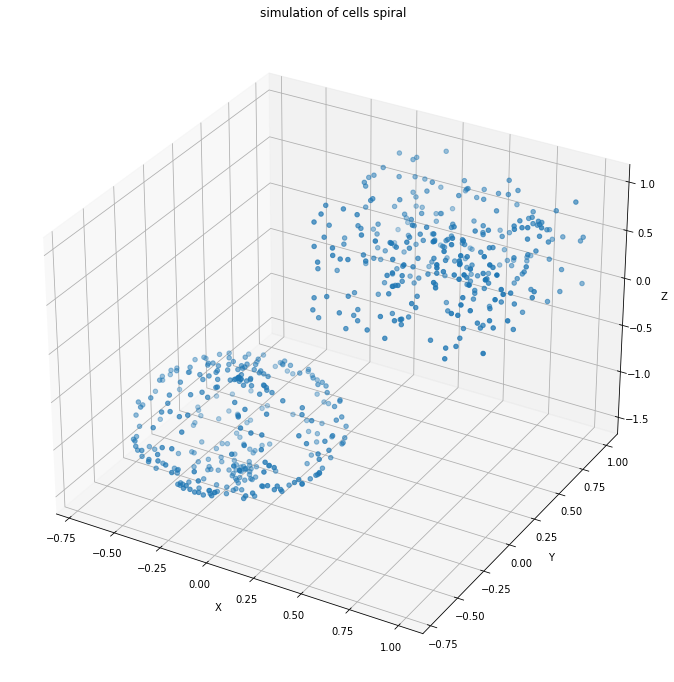

In [191]:
# generation of data (cells)

n = 600

np.random.seed(42) #fix the seed

#random cells data

#cells = np.random.rand(n, 3) 

#for ball data

#cells = np.random.rand(n, 3) 
#theta = [random.uniform(0, 2*np.pi) for i in range(0, n)] 
#phi = [random.uniform(0, 2*np.pi) for i in range(0, n)]
#cells[:, 0] = 10 +10*np.cos(theta)*np.sin(phi)
#cells[:, 1] = 10 +10*np.sin(theta)*np.sin(phi)
#cells[:, 2] = 10 +10*np.cos(phi)

#for line data

#cells = np.random.rand(n, 3) 
#cells[:, 0] = 0
#cells[:, 2] = 0

#for tore data

#a = 0.75
#b = 0.3
#theta = [random.uniform(0, 2*np.pi) for i in range(0, n)] 
#phi = [random.uniform(0, 2*np.pi) for i in range(0, n)]
#cells[:, 0] = 10+10*(a+b*np.cos(theta))*np.cos(phi)
#cells[:, 1] = 10+10*(a+b*np.cos(theta))*np.sin(phi)
#cells[:, 2] = 10+10*b*np.sin(theta)

#for cluster data

cells = np.random.rand(n, 3) 
theta = [random.uniform(0, 2*np.pi) for i in range(0, int(n/2))] 
phi = [random.uniform(0, 2*np.pi) for i in range(0, int(n/2))]
cells[0:int(n/2), 0] = 0.5*np.cos(theta)*np.sin(phi) - 0.2
cells[0:int(n/2), 1] =  0.5*np.sin(theta)*np.sin(phi) - 0.2
cells[0:int(n/2), 2] =  0.5*np.cos(phi) -1


#theta = [random.uniform(0, 2*np.pi) for i in range(0, int(n/2))] 
#phi = [random.uniform(0, 2*np.pi) for i in range(0, int(n/2))]
#cells[int(n/2):n, 0] =  0.5*np.cos(theta)*np.sin(phi) +0.2
#cells[int(n/2):n, 1] =  0.5*np.sin(theta)*np.sin(phi) +1
#cells[int(n/2):n, 2] =  0.5*np.cos(phi) + 0.2

#for spiral data

#cells = np.random.rand(n, 3) 
#theta = np.linspace(0, 4*np.pi,n)
#cells[:, 0] = np.cos(2*theta)*theta
#cells[:, 1] = np.sin(2*theta)*theta
#cells[:, 2] = theta
#cells[:, 0] = 0.5+4*np.pi+ 0.5*np.cos(2*theta)*theta
#cells[:, 1] = 0.5+4*np.pi+ 0.5*np.sin(2*theta)*theta
#cells[:, 2] = theta*0.2

#for reconstruction
cells = normalise(cells)

#plot
plot3D(cells,'spiral','simulation of cells spiral')

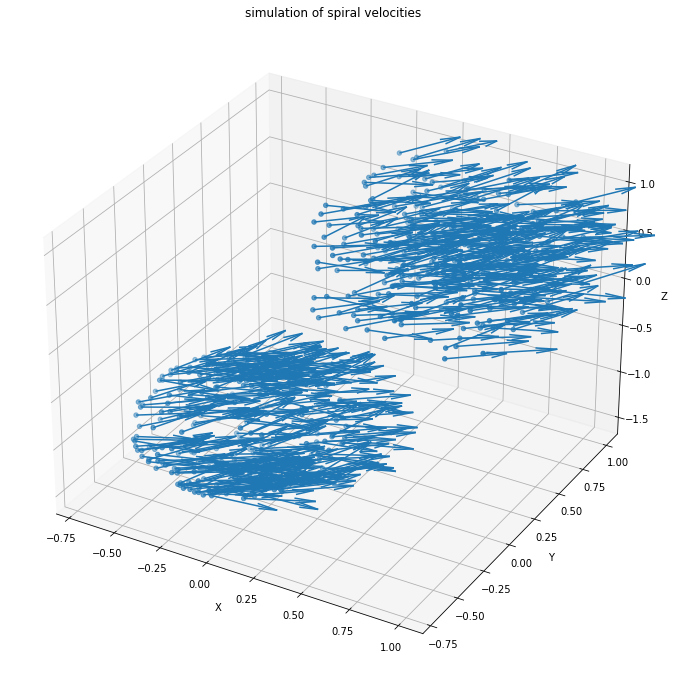

In [195]:
# generation of data (vector field)


velocity = np.random.rand(n, 3) #generate velocity random
theta = [random.uniform(0, 2*np.pi) for i in range(0, n)] #for ball data
phi = [random.uniform(0, 2*np.pi) for i in range(0, n)]

#for sparrow
#velocity[:, 0] = np.cos(2*theta + np.pi/2) #np.sin(theta)*np.cos(phi)
#velocity[:, 1] = np.sin(2*theta+ np.pi/2) #np.sin(theta)*np.sin(phi)
#velocity[:, 2] = 0 #np.cos(theta)

#same dir 

for i in range(velocity.shape[0]) :
    velocity[i, 0] = 4 + random.uniform(0, 2*np.pi) #generate velocity in a particular direction
    velocity[i, 1] = random.uniform(0, 2*np.pi)
    velocity[i, 2] = random.uniform(0, 2*np.pi)

norm = np.sqrt(velocity[:, 0]**2 + velocity[:, 1]**2+ velocity[:, 2]**2) 
velocity[:, 0] = velocity[:, 0]/norm
velocity[:, 1] = velocity[:, 1]/norm
velocity[:, 2] = velocity[:, 2]/norm

#plot
#print(velocity)

Vector_plot3D(cells,velocity, 'spiral velocities','simulation of spiral velocities')

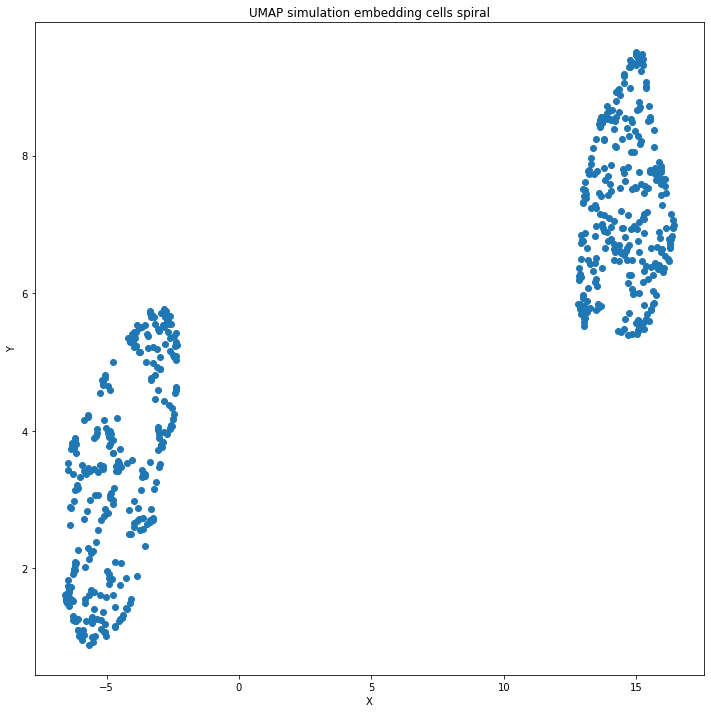

In [196]:
embedding = umap_mapping(cells,'UMAP simulation embedding cells spiral','UMAP simulation embedding cells spiral')

ParametricUMAP(optimizer=<keras.optimizer_v2.adam.Adam object at 0x32a00a2b0>, parametric_reconstruction=True)
Tue Jun  7 13:33:08 2022 Construct fuzzy simplicial set
Tue Jun  7 13:33:08 2022 Finding Nearest Neighbors
Tue Jun  7 13:33:08 2022 Finished Nearest Neighbor Search
Tue Jun  7 13:33:08 2022 Construct embedding
Epoch 1/10


2022-06-07 13:33:10.118385: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 20s 29ms/step - loss: -4431.7788 - reconstruction_loss: -4432.0977 - umap_loss: 0.3180
Epoch 2/10
294/294 [==============================] - 8s 28ms/step - loss: -87440.2969 - reconstruction_loss: -87440.4766 - umap_loss: 0.1860
Epoch 3/10
294/294 [==============================] - 9s 29ms/step - loss: -401252.3750 - reconstruction_loss: -401252.5000 - umap_loss: 0.1814
Epoch 4/10
294/294 [==============================] - 8s 28ms/step - loss: -1138115.7500 - reconstruction_loss: -1138115.8750 - umap_loss: 0.1801
Epoch 5/10
294/294 [==============================] - 8s 28ms/step - loss: -2680745.7500 - reconstruction_loss: -2680746.0000 - umap_loss: 0.1773
Epoch 6/10
294/294 [==============================] - 8s 28ms/step - loss: -5581593.5000 - reconstruction_loss: -5581593.5000 - umap_loss: 0.1756
Epoch 7/10
294/294 [==============================] - 9s 29ms/step - loss: -10464342.0000 - reconstruction_loss: -10464342.0000 - umap_loss: 0.173

2022-06-07 13:34:44.414919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - 0s 2ms/step
Tue Jun  7 13:34:44 2022 Finished embedding


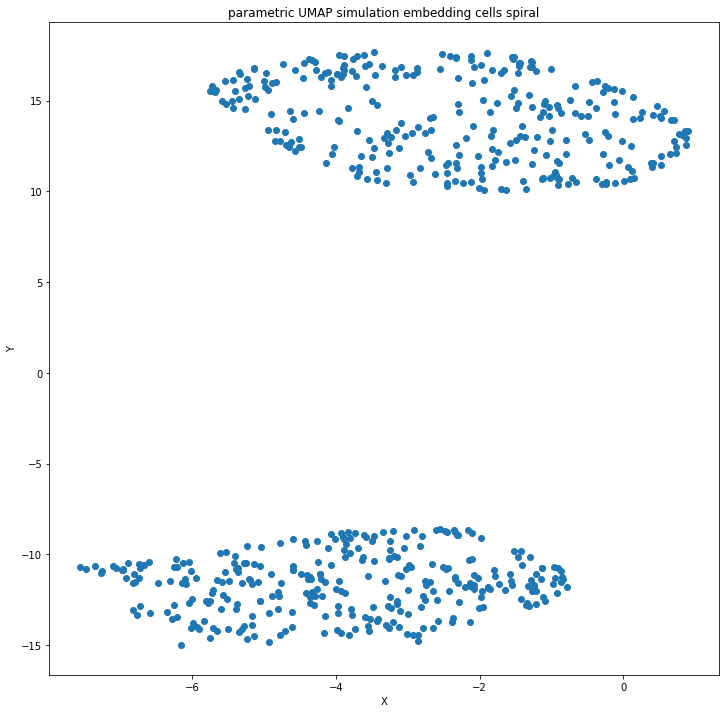

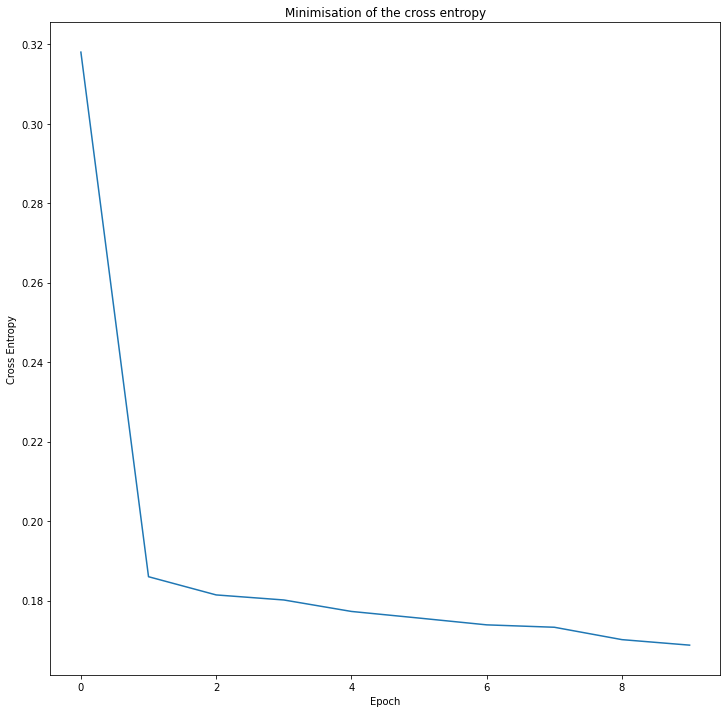

In [197]:
reconstruction = True
embedder, embedding_param = PUMAP_mapping(cells,'parametric UMAP simulation embedding cells spiral',reconstruction)

2022-06-07 13:34:45.289873: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 459ms/step


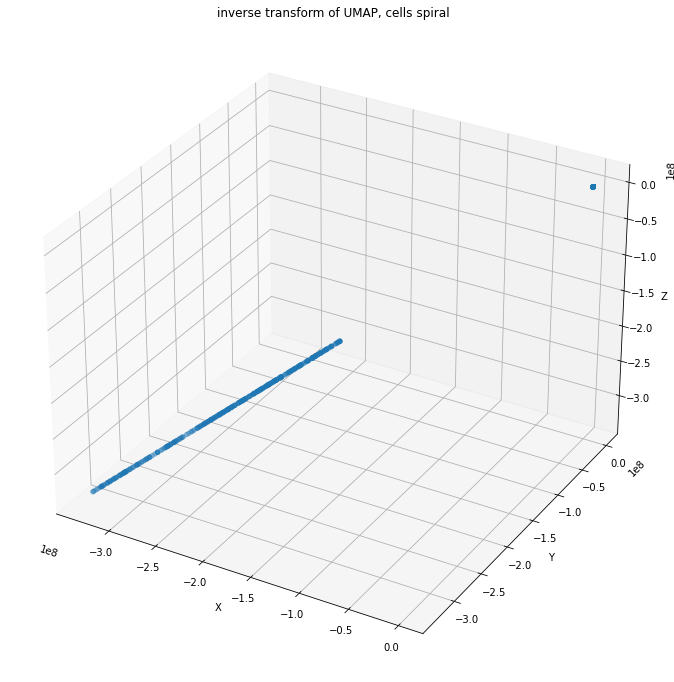

In [198]:
embedding_inverse = inversion(embedder,embedding_param,'inverse transform of UMAP, cells spiral')

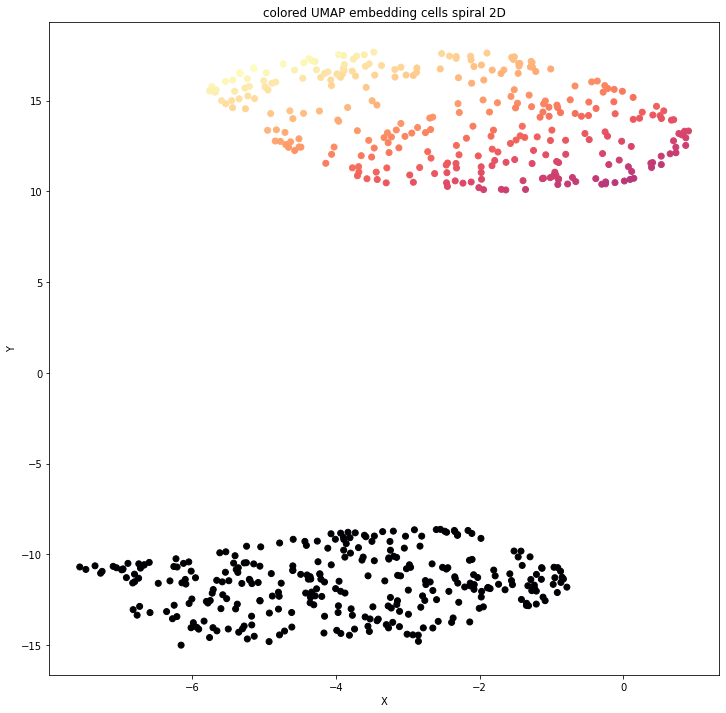

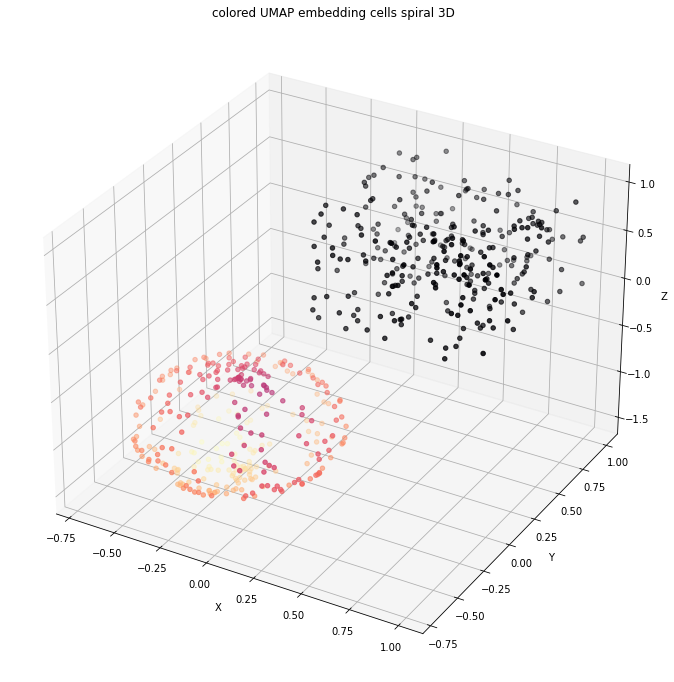

In [199]:
coloring(cells, embedding_inverse,embedding_param,[],'colored UMAP embedding cells spiral', 'colored UMAP embedding cells spiral')

In [200]:
dist = dist_point(cells, embedding_inverse)

distance between cells
mean :  216607023.9063085
max :  575848859.8496459
min :  2.999686259431446


velocity embedding

2022-06-07 13:34:46.405550: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 317ms/step


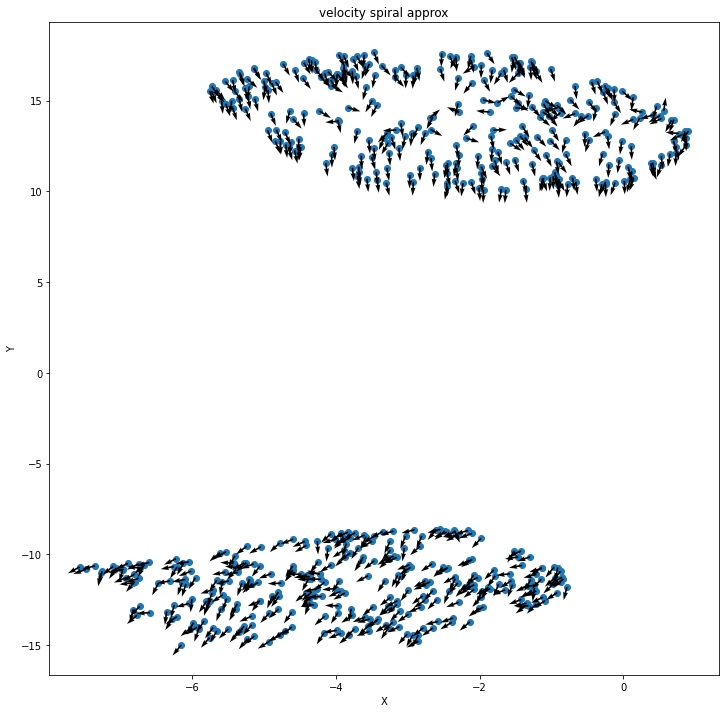

In [201]:
velo = velocity_calculus(embedder,embedding_param,velocity,cells, 'velocity spiral approx')

In [202]:
embedded_velocity = velocity_embedding(cells,embedder,velocity)

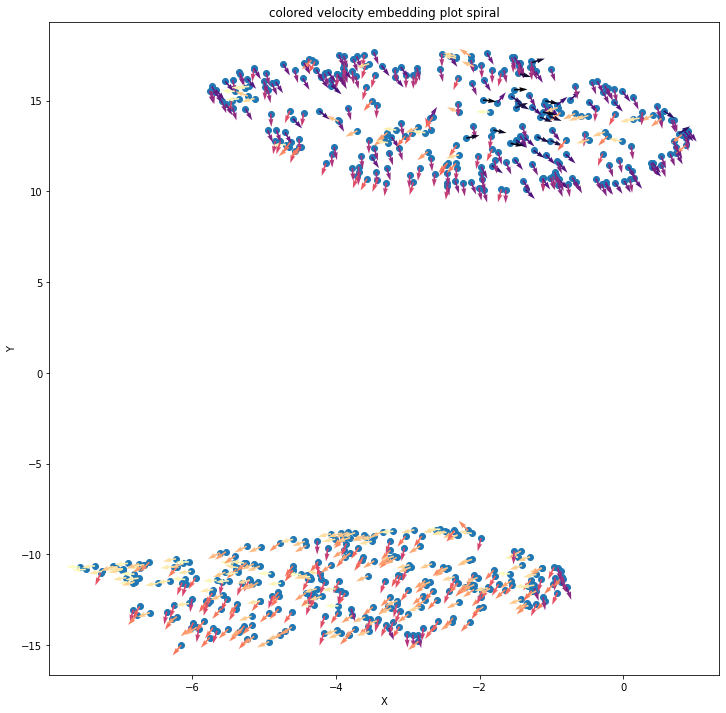

In [203]:
Vector_plot(embedding_param, embedded_velocity,'colored velocity embedding plot spiral', 'colored velocity embedding plot spiral',True)

In [204]:
d_v1 = dist_vector(velo,embedded_velocity)

distance between vector (in degree)
mean :  17.06200230782413
median :  8.163167774093434
max :  143.13032924638821
min :  0.0


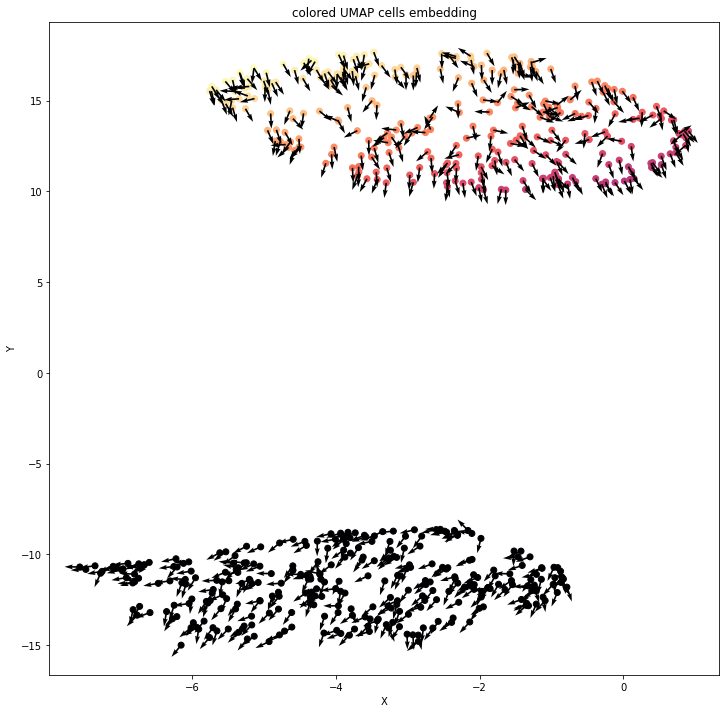

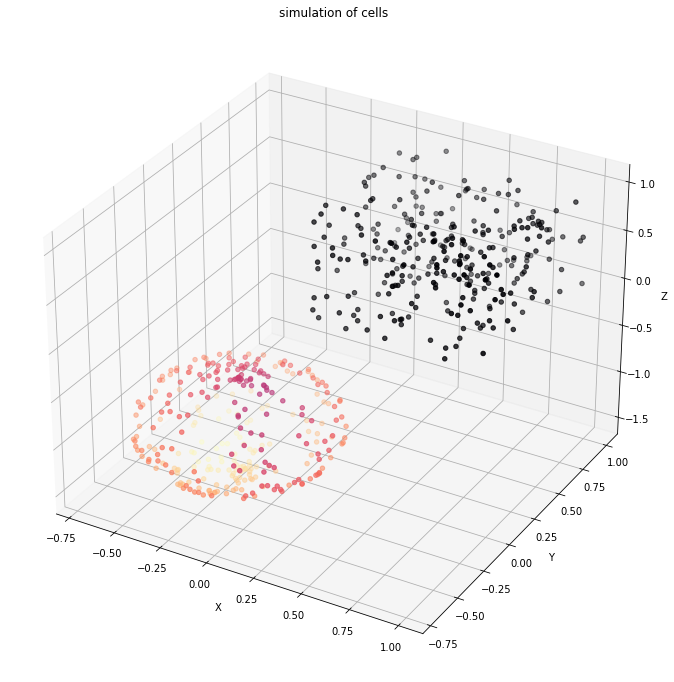

In [205]:
coloring(cells, embedding_inverse,embedding_param, embedded_velocity,'colored embedding plot spiral')

1/1 [==============================] - 0s 7ms/step


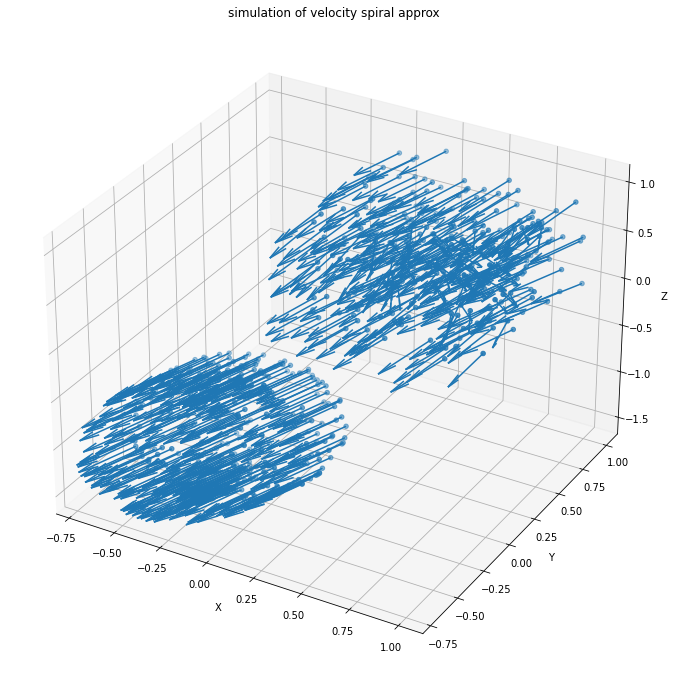

distance between vector (in degree)
mean :  143.18827360192915
median :  148.43371838406262
max :  178.83604735791886
min :  39.69128860886781


In [206]:
velo_invert = velocity_inverting(embedder,embedding_param,embedded_velocity,cells, 'simulation of velocity spiral approx')
d_v2 = dist_vector(velo_invert, velocity)

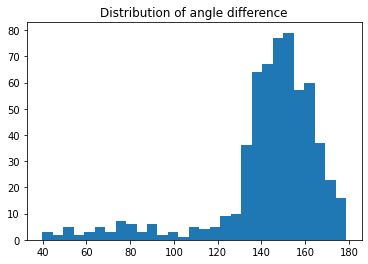

In [207]:
plt.hist(d_v2, bins='auto')  # arguments are passed to np.histogram
plt.title("Distribution of angle difference")
plt.savefig(fname = 'graph/histogram of angle approximation-original.png')
plt.show()

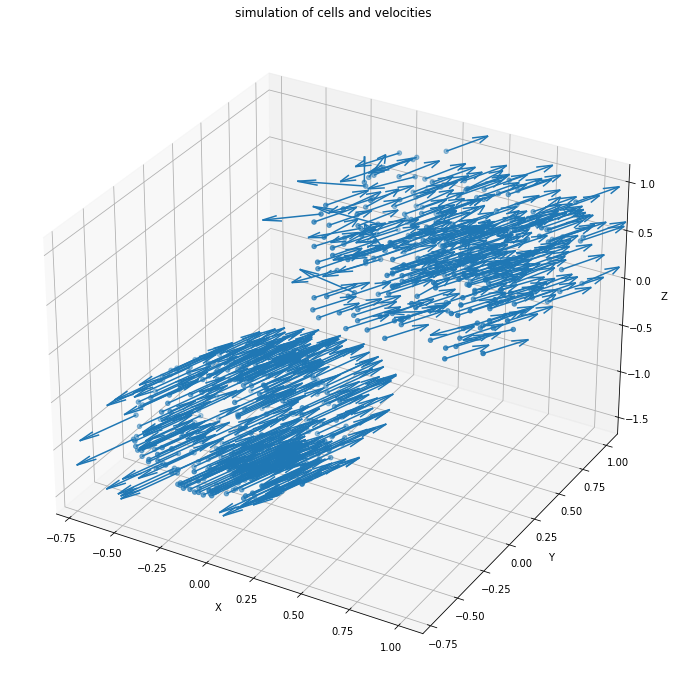

distance between vector (in degree)
mean :  44.79785167790493
median :  33.27333488169539
max :  172.2975847767551
min :  1.1639505018223524


In [208]:
if (reconstruction == True) :
    velo_invert2 = velocity_inversing(embedding_param,embedder,embedded_velocity)
    Vector_plot3D(cells,velo_invert2, 'reverse embedding of velocity spiral')
    d_v3 = dist_vector(velo_invert2, velocity)

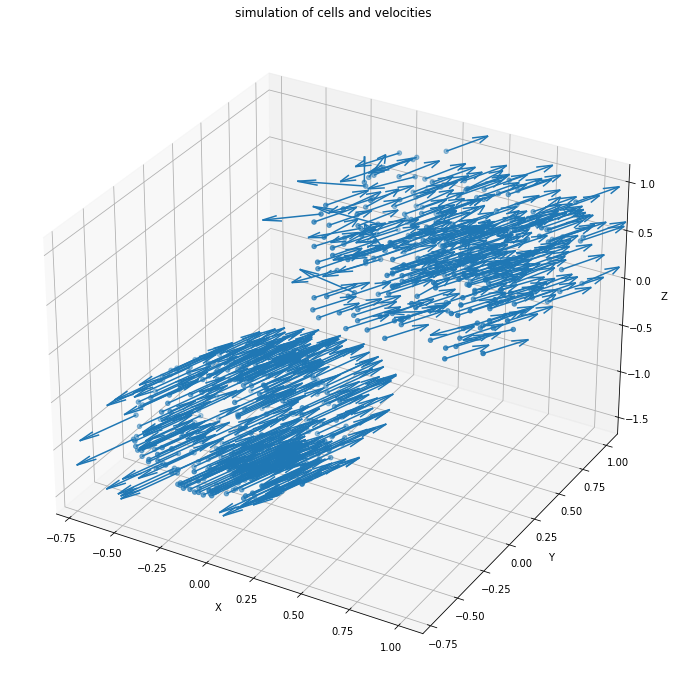

distance between vector (in degree)
mean :  44.79785167790493
median :  33.27333488169539
max :  172.2975847767551
min :  1.1639505018223524


In [209]:
if (reconstruction == True) :
    velo_invert2 = velocity_inversing_general(embedding_param,embedder,embedded_velocity)
    Vector_plot3D(cells,velo_invert2, 'reverse embedding of velocity spiral')
    d_v3 = dist_vector(velo_invert2, velocity)

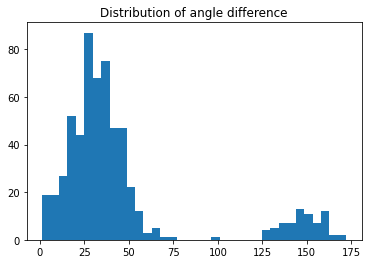

In [210]:
plt.hist(d_v3, bins='auto')  # arguments are passed to np.histogram
plt.title("Distribution of angle difference")
plt.savefig(fname = 'graph/histogram of angle reconstructed-original.png')
plt.show()

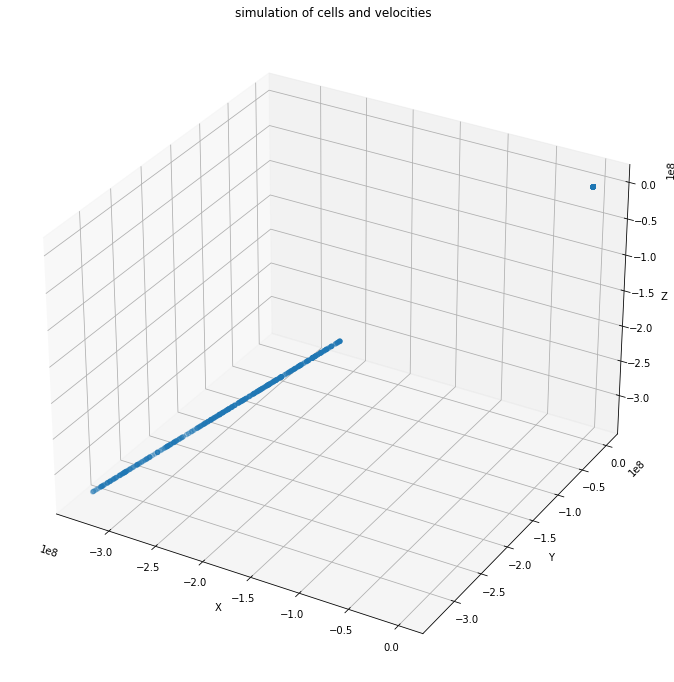

In [211]:
Vector_plot3D(embedding_inverse,velo_invert2, 'inversion of embedding and velocity')

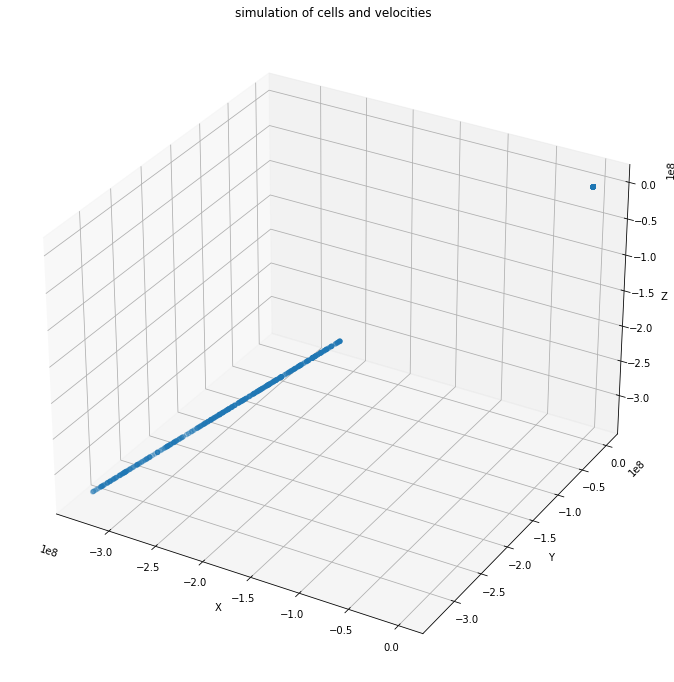

In [212]:
Vector_plot3D(embedding_inverse,velo_invert, 'inversion of embedding and velocity approx')

In [87]:
#d_v4 = dist_vector(velo_invert,velo_invert2)

In [213]:
pca = decomposition.PCA(n_components=2)
projection = pca.fit_transform(cells)

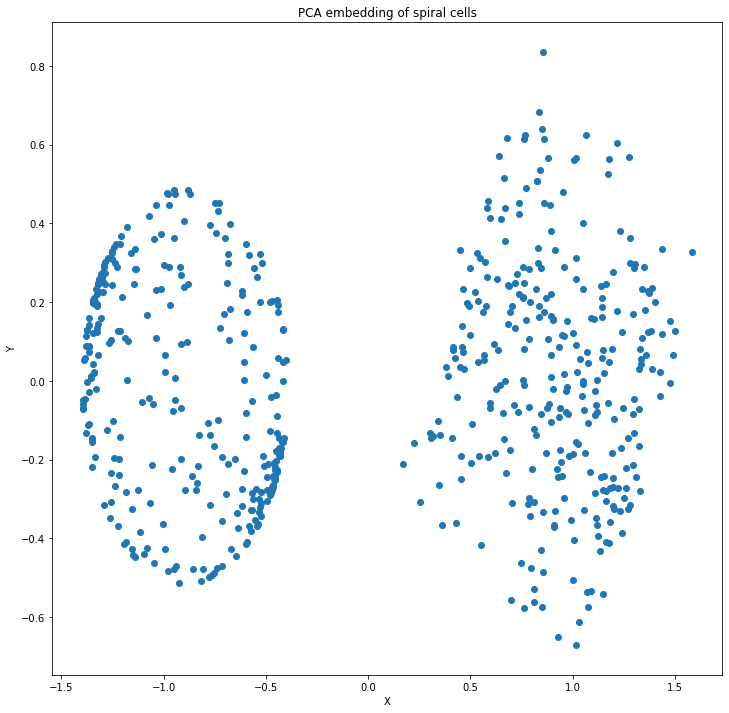

In [214]:
#we plot the original PCA embedding but we will recompute it for verification
plt.figure(figsize=(12, 12))
plt.title("PCA embedding of spiral cells")
plt.xlabel('X')
plt.ylabel('Y')
 
plt.scatter(projection[:, 0],
    projection[:, 1])

plt.savefig(fname = 'graph/PCA embedding of spiral cells.png')

plt.show()

In [215]:
R = pca.inverse_transform(projection)

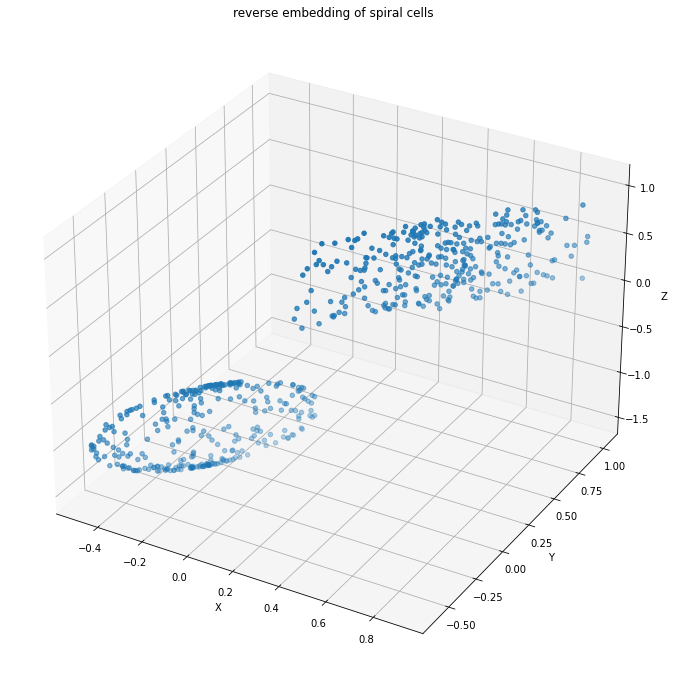

In [216]:
plot3D(R,'reverse embedding of spiral cells','reverse embedding of spiral cells')

In [217]:
embedded_velocity = velocity_embedding_pca(pca,velocity)

In [218]:
reconstruct_velocity = velocity_decoding_pca(pca,embedded_velocity)

(600, 2)
(2, 3)
(600, 3)


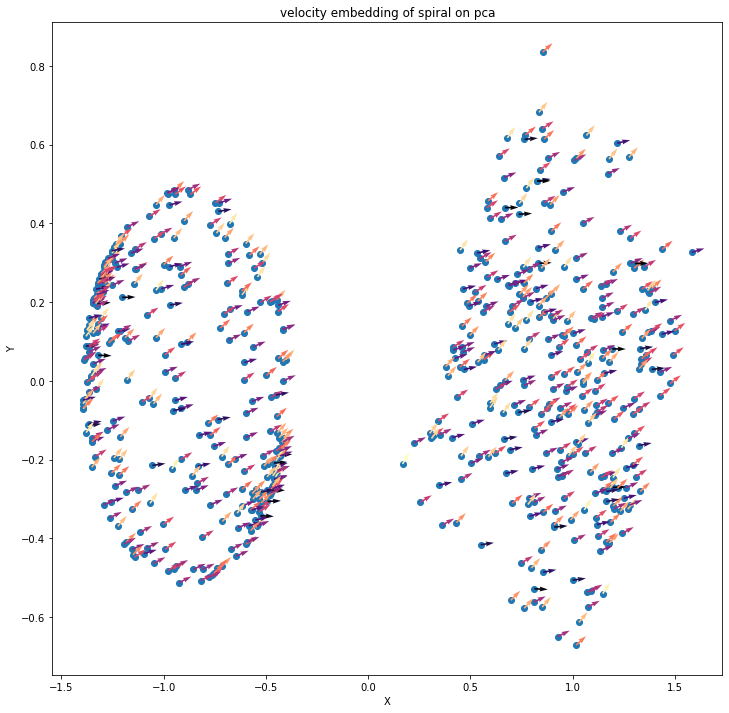

In [219]:
Vector_plot(projection, embedded_velocity,'velocity embedding of spiral on pca','velocity embedding of spiral on pca',True)

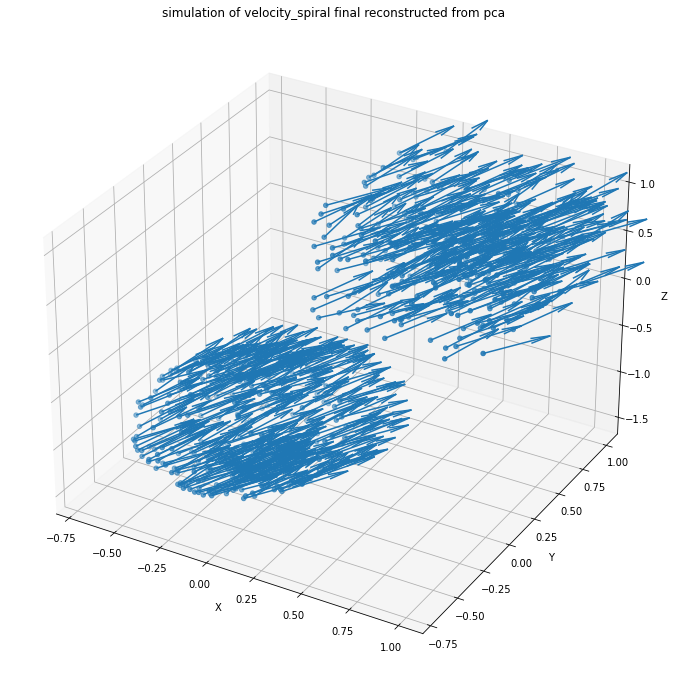

In [220]:
Vector_plot3D(cells,reconstruct_velocity, 'simulation of velocity_spiral final reconstructed from pca','simulation of velocity_spiral final reconstructed from pca')

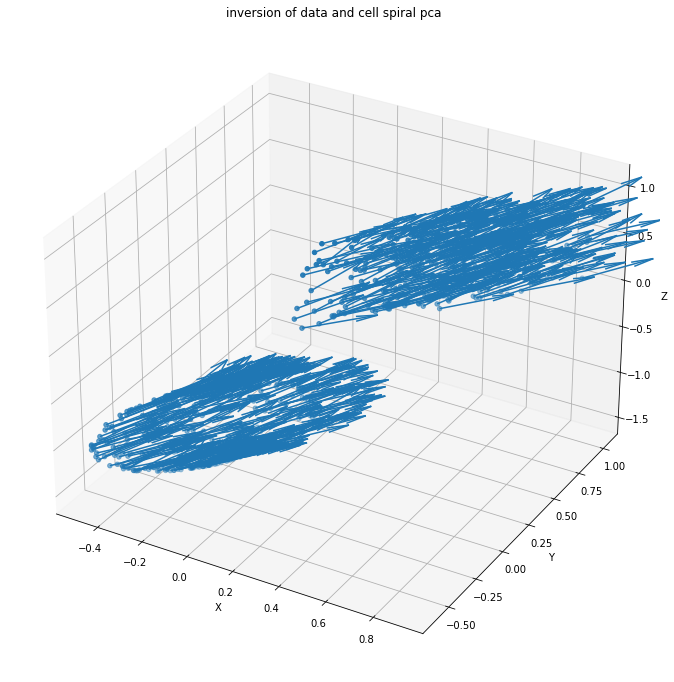

In [221]:
Vector_plot3D(R,reconstruct_velocity, 'inversion of data and cell spiral pca', 'inversion of data and cell spiral pca')

In [222]:
V = dist_vector(reconstruct_velocity,velocity)

distance between vector (in degree)
mean :  24.10116485928455
median :  23.840398684672095
max :  51.95639635612279
min :  0.16303211620660832


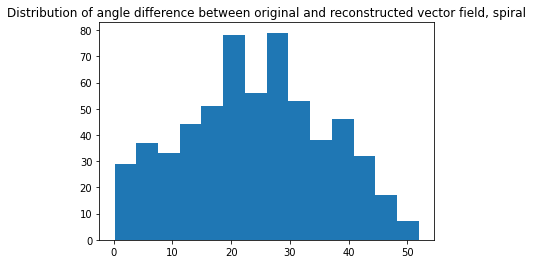

In [223]:
plt.hist(V, bins='auto')  # arguments are passed to np.histogram
plt.title("Distribution of angle difference between original and reconstructed vector field, spiral")
plt.savefig(fname = 'graph/histogram of angle spiral.png')
plt.show()

# 3] <b> application on biological data : exemple with a biological dataset<b> (and scvelo)

In [99]:
data = scv.datasets.dentategyrus() # or other ?
scv.pp.filter_and_normalize(data)
scv.pp.moments(data)
scv.tl.velocity(data, mode='stochastic')
velocity_p = data.layers['velocity']

data_p = normalise(data.X.toarray())
data_p = data.X.toarray()
umap_p = data.obsm['X_umap'] 

Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


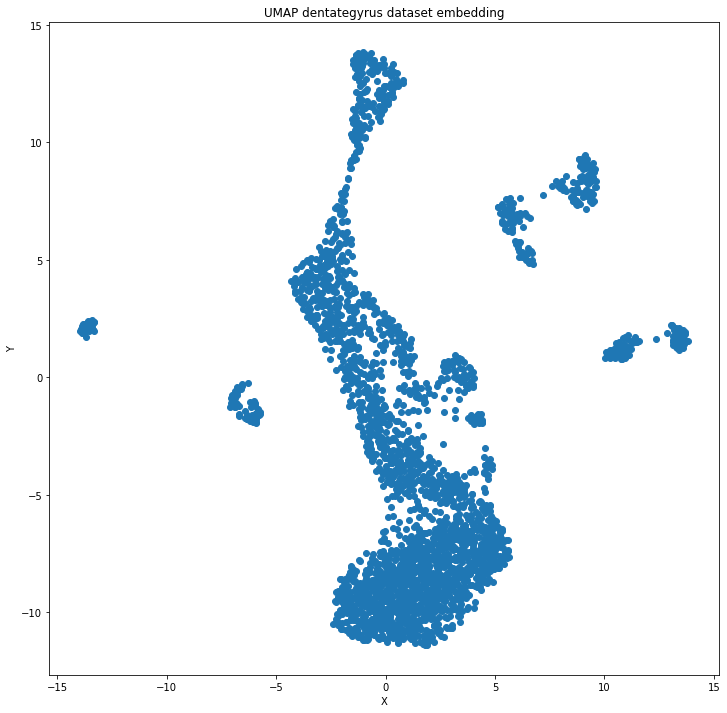

In [100]:
#plot
plt.figure(figsize=(12, 12))
plt.title("UMAP dentategyrus dataset embedding")
plt.xlabel('X')
plt.ylabel('Y')

plt.scatter(umap_p[:, 0],
    umap_p[:, 1])

plt.savefig(fname = 'graph/original umap.png')

plt.show()

In [101]:
scv.tl.velocity_graph(data)

computing velocity graph (using 1/10 cores)


  0%|          | 0/2930 [00:00<?, ?cells/s]

    finished (0:00:09) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_dentategyrus dataset.pdf


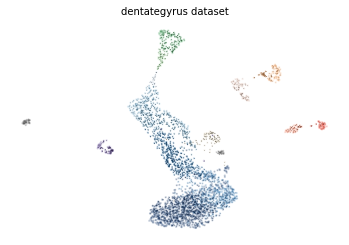

saving figure to file ./figures/scvelo_dentategyrus dataset grid.pdf


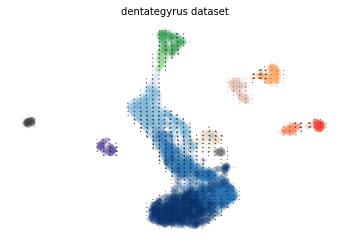

figure cannot be saved as pdf, using png instead.
saving figure to file ./figures/scvelo_dentategyrus dataset stream.png


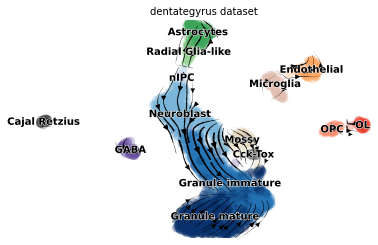

In [102]:
scv.pl.velocity_embedding(data, basis="umap", title = "dentategyrus dataset", save = 'dentategyrus dataset')
scv.pl.velocity_embedding_grid(data, basis='umap', title = "dentategyrus dataset", save = 'dentategyrus dataset grid')
scv.pl.velocity_embedding_stream(data, basis='umap', title = "dentategyrus dataset", save = 'dentategyrus dataset stream')

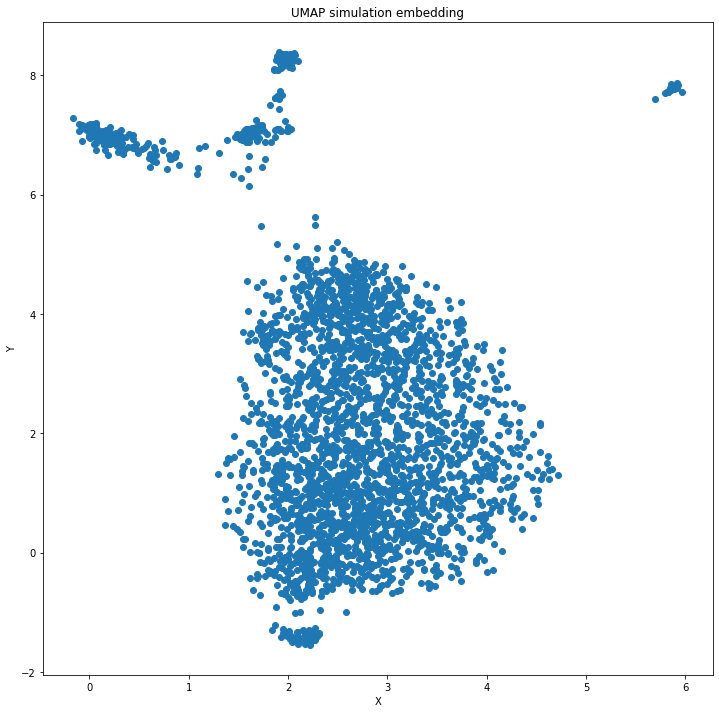

In [103]:
embedding = umap_mapping(data_p,'bio umap embedding')

ParametricUMAP(optimizer=<keras.optimizer_v2.adam.Adam object at 0x2bf222f10>, parametric_reconstruction=True)
Tue Jun  7 11:25:56 2022 Construct fuzzy simplicial set
Tue Jun  7 11:26:14 2022 Finding Nearest Neighbors
Tue Jun  7 11:26:14 2022 Finished Nearest Neighbor Search
Tue Jun  7 11:26:14 2022 Construct embedding
Epoch 1/10


2022-06-07 11:26:21.916813: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1130/1130 [==============================] - 84s 73ms/step - loss: -65498.5977 - reconstruction_loss: -65498.9688 - umap_loss: 0.4037
Epoch 2/10
1130/1130 [==============================] - 82s 73ms/step - loss: -1020466.1250 - reconstruction_loss: -1020466.6250 - umap_loss: 0.3822
Epoch 3/10
1130/1130 [==============================] - 81s 71ms/step - loss: -4528189.0000 - reconstruction_loss: -4528189.5000 - umap_loss: 0.3791
Epoch 4/10
1130/1130 [==============================] - 81s 72ms/step - loss: -12944857.0000 - reconstruction_loss: -12944857.0000 - umap_loss: 0.3772
Epoch 5/10
1130/1130 [==============================] - 81s 71ms/step - loss: -29297380.0000 - reconstruction_loss: -29297380.0000 - umap_loss: 0.3757
Epoch 6/10
1130/1130 [==============================] - 82s 73ms/step - loss: -60406492.0000 - reconstruction_loss: -60406492.0000 - umap_loss: 0.3749
Epoch 7/10
1130/1130 [==============================] - 83s 73ms/step - loss: -118936384.0000 - reconstruction_loss

2022-06-07 11:40:03.671698: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


92/92 [==============================] - 0s 3ms/step
Tue Jun  7 11:40:04 2022 Finished embedding


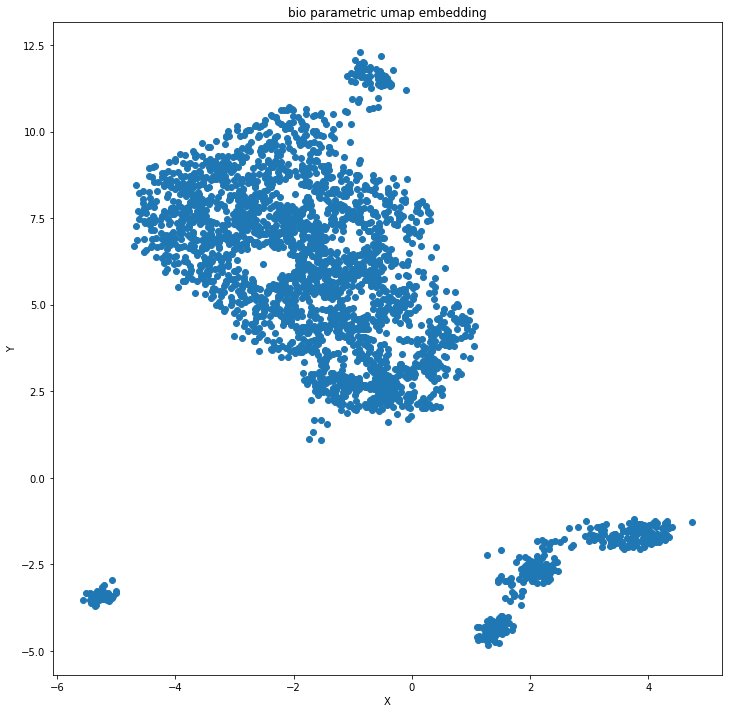

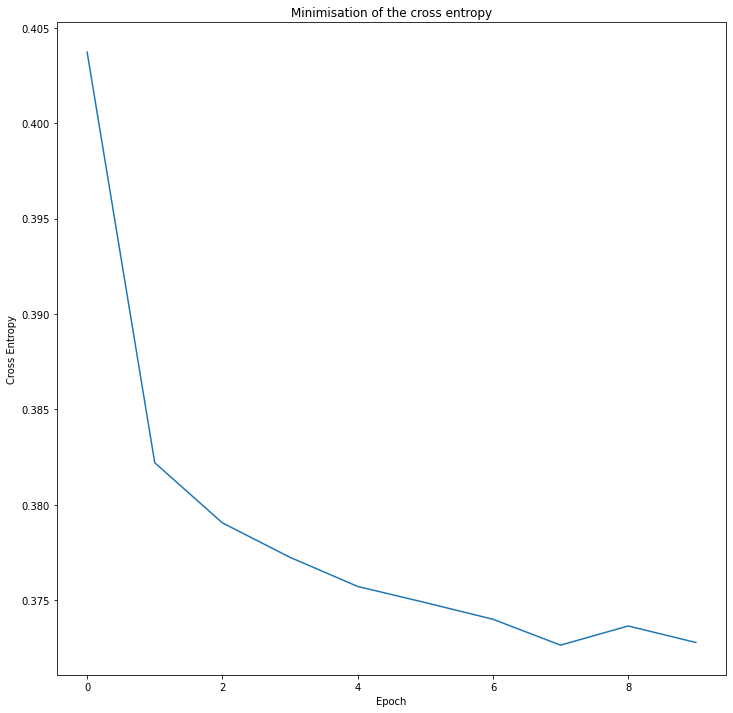

In [104]:
reconstruction = True
embedder, embedding_param = PUMAP_mapping(data_p, 'bio parametric umap embedding',reconstruction)

3/3 [==============================] - 0s 17ms/step


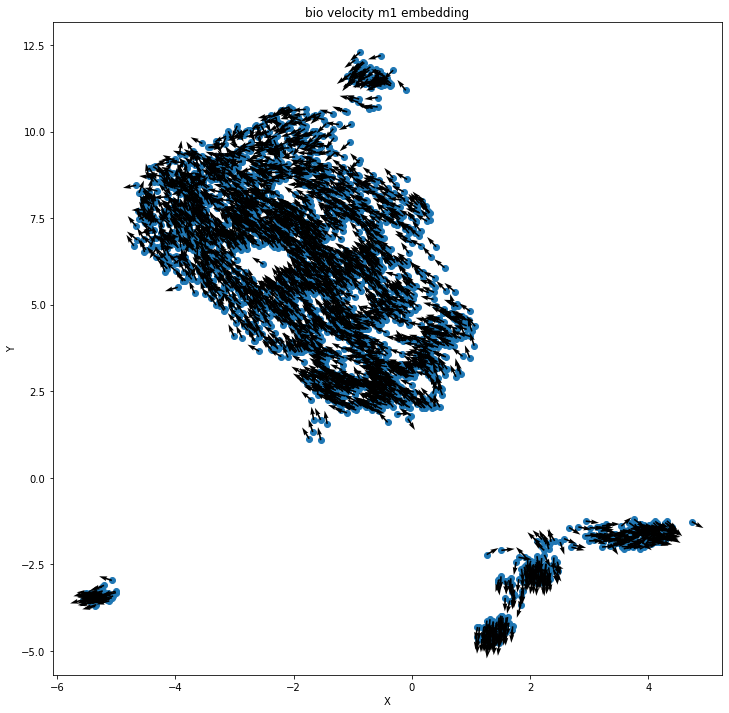

In [105]:
velo = velocity_calculus(embedder,embedding_param,velocity_p,data_p,'bio velocity m1 embedding') #method 1

In [106]:
embedded_velocity = velocity_embedding(data_p,embedder,velocity_p)

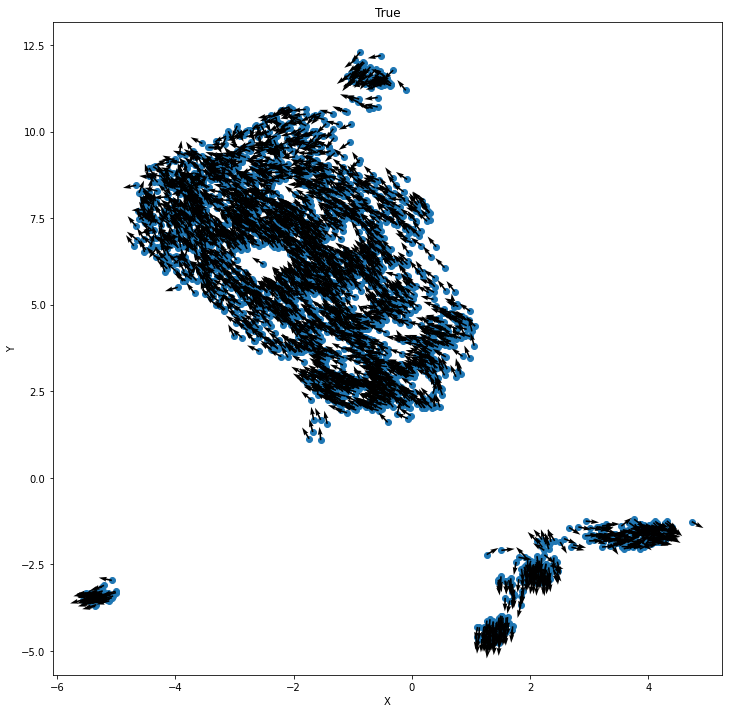

In [107]:
Vector_plot(embedding_param, embedded_velocity,'bio velocity embedding', True)

In [108]:
D = dist_point(velo,embedded_velocity)

distance between cells
mean :  0.04784345580889097
max :  1.9084850540530918
min :  2.2442059043905862e-08


computing velocity graph (using 1/10 cores)


  0%|          | 0/2930 [00:00<?, ?cells/s]

    finished (0:00:09) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_dentategyrus dataset umap.pdf


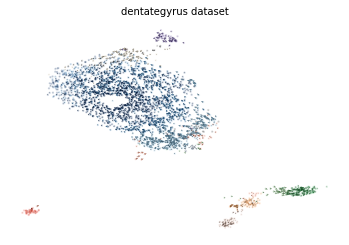

saving figure to file ./figures/scvelo_dentategyrus dataset umap grid.pdf


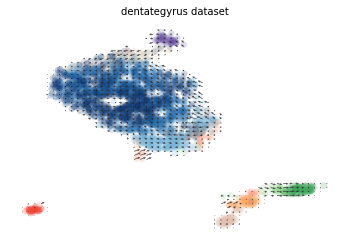

figure cannot be saved as pdf, using png instead.
saving figure to file ./figures/scvelo_dentategyrus dataset umap stream.png


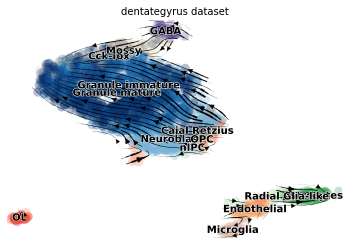

In [109]:
data.obsm['X_umap'] = embedding_param
scv.tl.velocity_graph(data)
scv.pl.velocity_embedding(data, basis="umap", title = "dentategyrus dataset", save = 'dentategyrus dataset umap')
scv.pl.velocity_embedding_grid(data, basis='umap', title = "dentategyrus dataset", save = 'dentategyrus dataset umap grid')
scv.pl.velocity_embedding_stream(data, basis='umap', title = "dentategyrus dataset", save = 'dentategyrus dataset umap stream')

In [110]:
scvelo_embedding = data.obsm['velocity_umap'][:,0:2]

In [111]:
embedding_inverse = inversion(embedder,embedding_param,'inverse plot_bio')

3/3 [==============================] - 0s 14ms/step


2022-06-07 11:41:44.696616: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


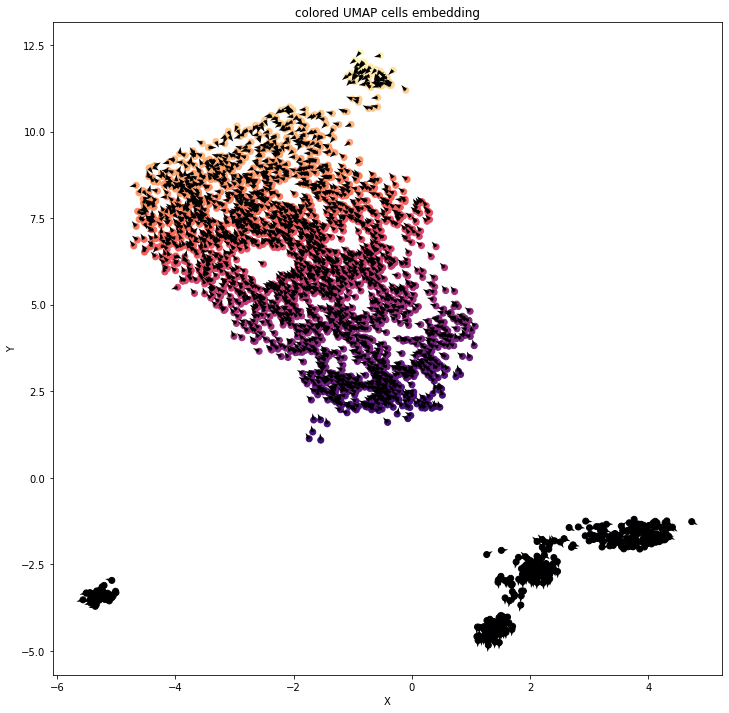

In [112]:
coloring(data_p, embedding_inverse,embedding_param, embedded_velocity,'colored embedding plot_bio')

In [113]:
if (reconstruction == True) :
    velo_invert2 = velocity_inversing_general(embedding_param,embedder,embedded_velocity,data_p.shape[1])

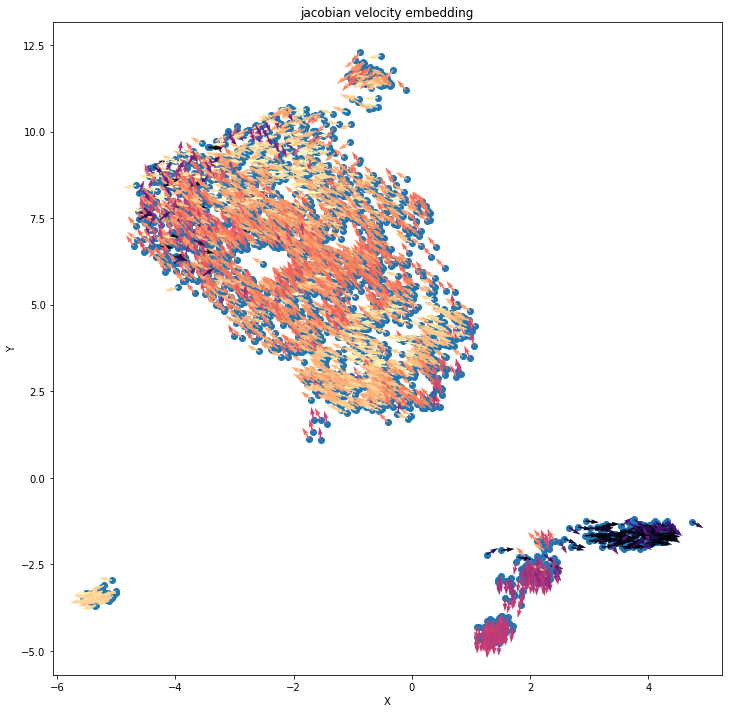

In [114]:
Vector_plot(embedding_param, embedded_velocity,'jacobian velocity embedding','jacobian velocity embedding', True)

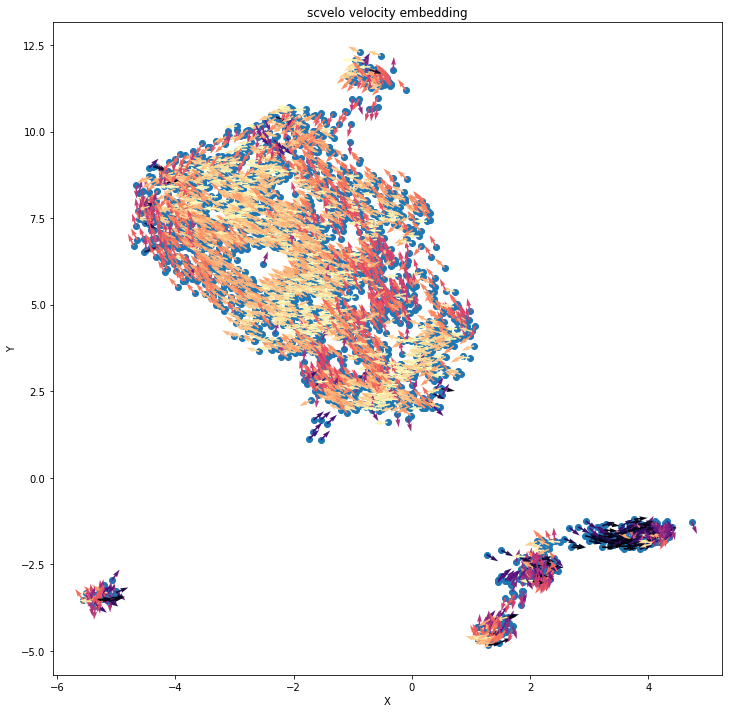

In [115]:
Vector_plot(embedding_param, scvelo_embedding,'scvelo velocity embedding','scvelo velocity embedding', True)

In [116]:
D = dist_vector(scvelo_embedding,embedded_velocity)

distance between vector (in degree)
mean :  33.8481811288582
median :  24.37683916987754
max :  179.7852186867926
min :  0.081518322068291


In [117]:
D = dist_vector(velocity_p, velo_invert2)

distance between vector (in degree)
mean :  92.26742905565605
median :  92.95500553753402
max :  94.86573650705496
min :  85.612782972989


distance between cells
mean :  0.44618983052865874
max :  1.999978673924871
min :  5.2136397903449315e-05


(5780, 14319)

(2930, 13913)

# 4] <b>PCA ground truth : comparison between jacobian and scVelo method

In [110]:
data = scv.datasets.bonemarrow()

In [111]:
scv.pp.filter_and_normalize(data)
scv.pp.moments(data,n_pcs= 50)
scv.tl.velocity(data, mode='stochastic')
velocity_p = data.layers['velocity']
scv.tl.velocity_graph(data)

Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:03) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/10 cores)


  0%|          | 0/5780 [00:00<?, ?cells/s]

    finished (0:00:21) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [112]:
data_p = data.X.toarray()
PCA = data.obsm['X_pca']

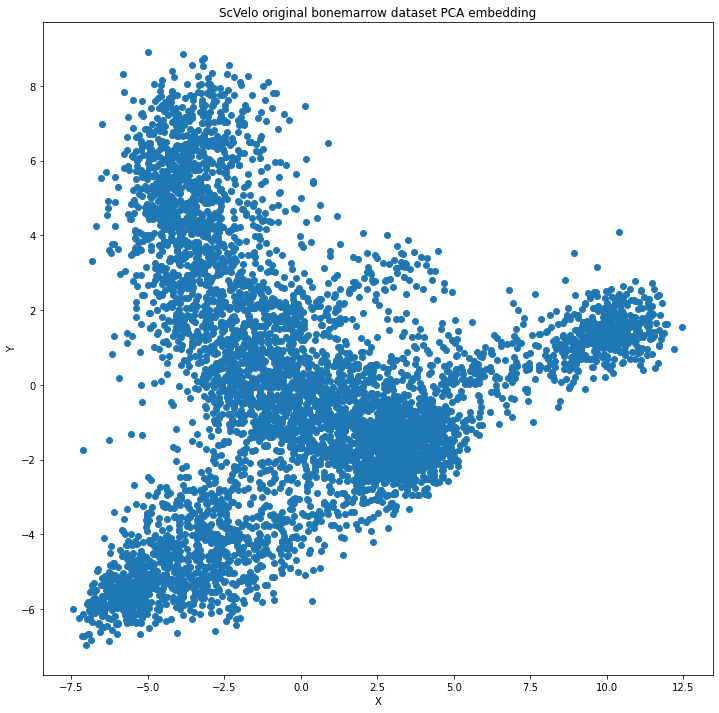

In [113]:
#we plot the original PCA embedding but we will recompute it for verification
plt.figure(figsize=(12, 12))
plt.title("ScVelo original bonemarrow dataset PCA embedding")
plt.xlabel('X')
plt.ylabel('Y')
 
plt.scatter(PCA[:, 0],
    PCA[:, 1])

plt.savefig(fname = 'graph/original pca.png')

plt.show()

In [114]:
# first pca : use at high dimension data
pca_50 = decomposition.PCA(n_components=50)
projection_50 = pca_50.fit_transform(data_p)

In [115]:
embedded_velocity_50 = velocity_embedding_pca(pca_50,velocity_p) #embedd the velocity high dim

In [116]:
# second pca : use at low dimension data
pca = decomposition.PCA(n_components=2)
projection = pca.fit_transform(projection_50)

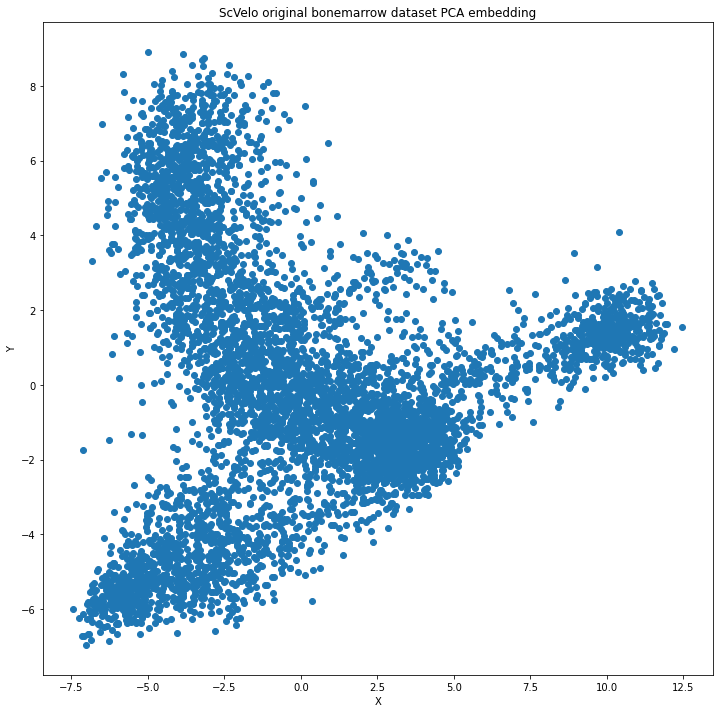

In [117]:
#we plot the projection 
plt.figure(figsize=(12, 12))
plt.title("ScVelo original bonemarrow dataset PCA embedding")
plt.xlabel('X')
plt.ylabel('Y')
 
plt.scatter(projection[:, 0],
    projection[:, 1])

plt.savefig(fname = 'graph/original pca.png')

plt.show()

In [118]:
Df = dist_point(PCA[:,0:2],projection) #same !

distance between cells
mean :  4.262928e-06
max :  2.4664803e-05
min :  0.0


In [119]:
pca.inverse_transform(projection) # do the same thing data pca_decoding but for point

array([[-1.7200963e+00, -4.2398906e+00,  4.4870322e-07, ...,
         4.2289074e-07, -3.1152248e-07, -4.5655970e-08],
       [ 3.9611111e+00, -1.5737898e+00, -8.1818740e-08, ...,
         4.3716375e-07, -3.0800774e-07, -2.3608040e-08],
       [-1.2469510e+00,  8.0075140e+00, -2.0693219e-06, ...,
         4.3073558e-07, -3.1846216e-07, -9.2073691e-08],
       ...,
       [-3.5663130e+00, -1.4908800e+00, -1.2265102e-07, ...,
         4.2025360e-07, -3.1483910e-07, -6.7328351e-08],
       [-6.3127370e+00, -6.2244153e+00,  8.4245073e-07, ...,
         4.1144702e-07, -3.1446646e-07, -6.4164411e-08],
       [ 8.7993604e-01, -4.2550278e-01, -3.2777501e-07, ...,
         4.3085879e-07, -3.1147420e-07, -4.5975455e-08]], dtype=float32)

In [120]:
D = dist_point(pca.inverse_transform(projection),projection_50) 

distance between cells
mean :  7.061641
max :  15.377476
min :  3.4231105


In [121]:
sparse.csr_matrix(projection_50)

<5780x50 sparse matrix of type '<class 'numpy.float32'>'
	with 289000 stored elements in Compressed Sparse Row format>

In [122]:
data_50 = anndata.AnnData(X = projection_50)
data_50.layers['velocity'] = embedded_velocity_50
data_50.obsm['X_pca'] = projection
data_50.uns['velocity_graph'] = data.uns['velocity_graph']

In [123]:
embedded_velocity = velocity_embedding_pca(pca,embedded_velocity_50) #embedd the velocity low dim

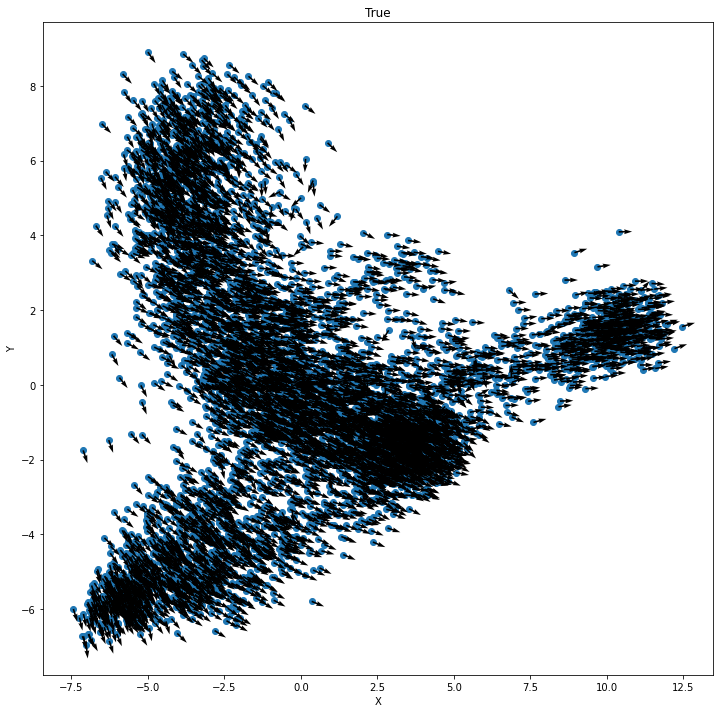

In [124]:
Vector_plot(projection, embedded_velocity,'pca', True)

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_pca dataset stream.pdf


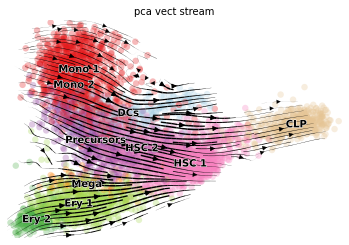

In [125]:
scv.pl.velocity_embedding_stream(data, basis='pca', title = "pca vect stream", save = 'pca dataset stream')

In [126]:
scvelo_embedding_original = data.obsm['velocity_pca'][:,0:2]

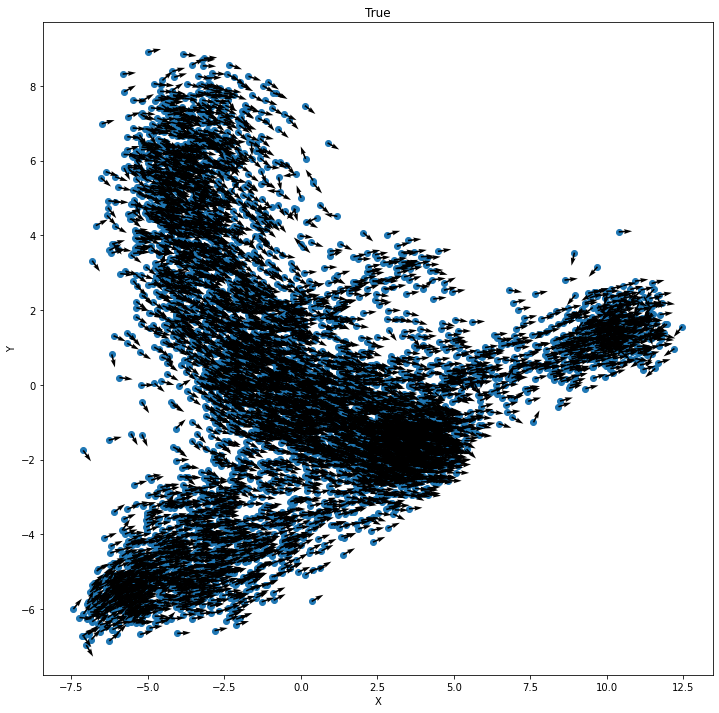

In [127]:
Vector_plot(projection, scvelo_embedding_original,'pca scvelo', True)

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
figure cannot be saved as pdf, using png instead.
saving figure to file ./figures/scvelo_pca dataset stream.png


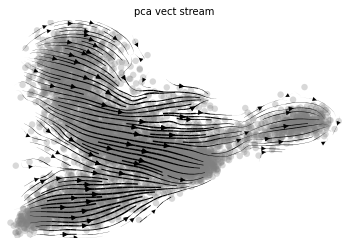

In [128]:
scv.pl.velocity_embedding_stream(data_50, basis='pca', title = "pca vect stream", save = 'pca dataset stream')

In [129]:
scvelo_embedding = data_50.obsm['velocity_pca'][:,0:2]

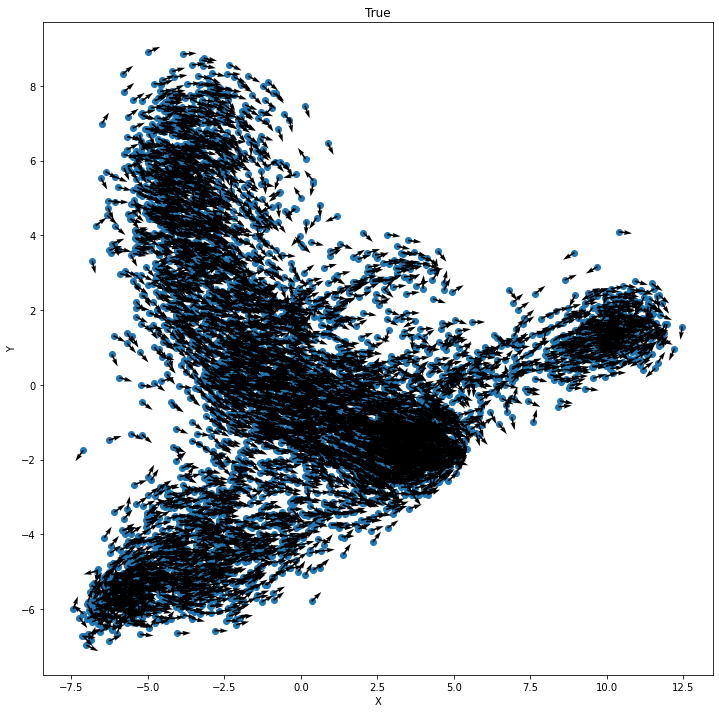

In [130]:
Vector_plot(projection, scvelo_embedding,'pca scvelo', True)

In [131]:
D = dist_vector(scvelo_embedding,embedded_velocity)

distance between vector (in degree)
mean :  27.165382324400817
median :  18.269880507441425
max :  179.47131466940962
min :  0.0


In [157]:
D = dist_vector(scvelo_embedding,scvelo_embedding_original)

distance between vector (in degree)
mean :  12.545628919486663
median :  7.529875101959416
max :  177.9431057554782
min :  0.0030700850336238157


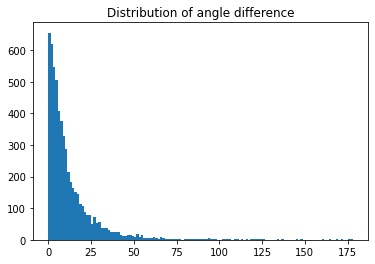

In [133]:
plt.hist(D, bins='auto')  # arguments are passed to np.histogram
plt.title("Distribution of angle difference")
plt.savefig(fname = 'histogram of angle.png')
plt.show()

In [134]:
reconstruct_point = velocity_decoding_pca(pca,PCA[:,0:2])

(5780, 2)
(2, 50)
(5780, 50)


In [158]:
D_reconstruct = dist_point(reconstruct_point, projection_50)

distance between cells
mean :  7.061641
max :  15.377473
min :  3.4231095


In [136]:
reconstruct_velocity_pca = velocity_decoding_pca(pca,embedded_velocity)

(5780, 2)
(2, 50)
(5780, 50)


In [159]:
D_reconstruct_velo_pca = dist_vector(embedded_velocity_50, reconstruct_velocity_pca)

distance between vector (in degree)
mean :  74.38828925342614
median :  74.40644038624805
max :  87.89384263248249
min :  60.203870456262926


In [138]:
reconstruct_velocity_sc = velocity_decoding_pca(pca,scvelo_embedding)

(5780, 2)
(2, 50)
(5780, 50)


In [160]:
D_reconstruct_velo_scvelo = dist_vector(embedded_velocity_50, reconstruct_velocity_sc)

distance between vector (in degree)
mean :  77.16139027032565
median :  76.06683947315798
max :  110.5007423745277
min :  60.23459057836424


In [140]:
reconstruct_velocity_sc_original = velocity_decoding_pca(pca,scvelo_embedding_original)

(5780, 2)
(2, 50)
(5780, 50)


In [161]:
D_reconstruct_velo_scvelo_original = dist_vector(embedded_velocity_50, reconstruct_velocity_sc_original)

distance between vector (in degree)
mean :  76.84755629124663
median :  75.82521082081425
max :  110.08972510251432
min :  60.673937870222304


In [142]:
D = dist_point(reconstruct_velocity_pca,embedded_velocity_50)

distance between cells
mean :  6.651238
max :  11.635771
min :  2.7093372


In [143]:
D = dist_point(reconstruct_velocity_sc,embedded_velocity_50)

distance between cells
mean :  6.699247962640466
max :  11.741627287368285
min :  2.71164614835733


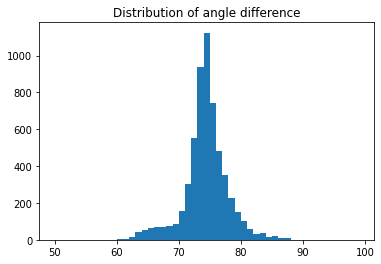

In [165]:
bar= list(range(50,100))
plt.hist(D_reconstruct_velo_pca, bins=bar)  # arguments are passed to np.histogram
plt.title("Distribution of angle difference")
plt.savefig(fname = 'histogram of angle_jacobian.png')
plt.show()

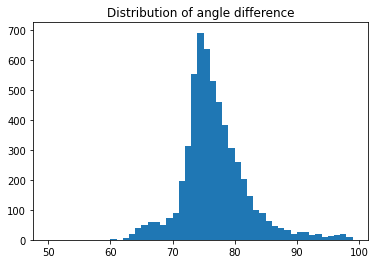

In [166]:
plt.hist(D_reconstruct_velo_scvelo, bins=bar)  # arguments are passed to np.histogram
plt.title("Distribution of angle difference")
plt.savefig(fname = 'histogram of angle_scvelo.png')
plt.show()

In [71]:
#Cov = np.cov(embedded_velocity_50,reconstruct_velocity_pca)

#plt.hist(Cov, bins='auto')  # arguments are passed to np.histogram
#plt.title("Distribution of covariance")
#plt.savefig(fname = 'histogram of angle.png')
#plt.show()

#Cov = np.cov(embedded_velocity_50,reconstruct_velocity_sc)#

#plt.hist(Cov, bins='auto')  # arguments are passed to np.histogram
#plt.title("Distribution of covariance")
#plt.savefig(fname = 'histogram of angle.png')
#plt.show()

In [65]:
#from scipy.stats import pearsonr

In [66]:
#corr = pearsonr(velocity_p,reconstruct_velocity)

#plt.hist(Cov, bins='auto')  # arguments are passed to np.histogram
#plt.title("Distribution of correlation")
#plt.savefig(fname = 'histogram of angle.png')
#plt.show()